# Wikipedia Network Analysis
## Full Project by Forrest Hangen

In [68]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk

from bs4 import BeautifulSoup as bs
import requests
import time
import random

import re

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import networkx as nx

import igraph as ig
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

# Step 1. Training Model to Identify People in Wikipedia Article Summary
(This will use the data and model I developed in Text Classification - Identifying People.ipynb. I did not label all the data I gathered (60000+ article summaries, but if anyone wants to continue labeling, be my guest!))

In [2]:
df_label = pd.read_csv('wiki_desc_dataset_no_duplicates.csv')

In [3]:
df_label['LABEL'].value_counts().loc['PERSON'] /sum(df_label['LABEL'].value_counts())

0.32715462610899876

In [4]:
df_labled = pd.read_csv('wiki_desc_dataset_no_duplicates.csv')
df_labled_only = (df_labled.dropna()
                            .drop(columns= 'Unnamed: 0'))
df_labled_only['LABEL'] = df_labled_only['LABEL'].apply(lambda x: 1 if x == 'PERSON' else 0)
df_labled_only.head()

,LABEL,Titles,Text
0,1,Charles H. Percy,"Charles Harting Percy (September 27, 1919 – Se..."
1,0,Head of state,A head of state (or chief of state) is the pub...
2,1,Henry Winkler,"Henry Franklin Winkler (born October 30, 1945)..."
3,0,La Violencia,La Violencia (Spanish pronunciation: [la βjoˈl...
4,0,London Buses route 176,London Buses route 176 is a Transport for Lond...


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_labled_only['Text'], 
                                                    df_labled_only['LABEL'], 
                                                    random_state=42, train_size= .97)
len(X_train), len(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(6122, 190)

In [6]:
count_final = CountVectorizer(lowercase=False, min_df = 30, ngram_range=(1,3)).fit(X_train)

X_train_matrix = count_final.transform(X_train)
X_test_matrix = count_final.transform(X_test)

log_final = LogisticRegression(solver = 'newton-cg', C=.1).fit(X_train_matrix, y_train)

In [7]:
y_train_finalpred = log_final.predict(X_train_matrix)
y_test_finalpred = log_final.predict(X_test_matrix)

print('TRAIN')
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_train, y_train_finalpred),
                                                     roc_auc_score(y_train, y_train_finalpred)))
print(confusion_matrix(y_train, y_train_finalpred))
print()
print('TEST')
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_test, y_test_finalpred),
                                                     roc_auc_score(y_test, y_test_finalpred)))
print(confusion_matrix(y_test, y_test_finalpred))

TRAIN
Log Reg:
Accuracy: 0.9942829140803658
ROC AUC: 0.9925539222953105
[[4106   10]
 [  25 1981]]

TEST
Log Reg:
Accuracy: 0.9789473684210527
ROC AUC: 0.9847328244274809
[[127   4]
 [  0  59]]


This level of accuracy is perfect for what I'm trying to do here.

# Step 2. Gathering the Data!

In [ ]:
all_info = parse_page('Benjamin Franklin', all_info)

In [18]:
%%time

all_info = gather_all_data()

ON APP_BF
ON NEXT LEVELbf: 93/93                                                                                                    
 


Wall time: 51min 12s 1265/1265                                                                                                    


In [17]:
def gather_all_data():
    approved = []
    person_links_db = {}
    all_checked = []
    got_links = []
    api_call = "http://en.wikipedia.org/w/api.php?action=parse&format=json&page="

    all_info = {'app': approved, 'pldb':person_links_db, 'all':all_checked, 'api':api_call, 'got':got_links}
    
    all_info = parse_page('Benjamin Franklin', all_info)
    
    app_bf = all_info['app'].copy()
    print('ON APP_BF')
    for i, person in enumerate(app_bf):
        if person not in all_info['got']:
            all_info = parse_page(person, all_info)
        print('Finished app_bf: {0}/{1}{2}'.format(i+1, len(app_bf), ' '*100), end="\r")


    next_level = all_info['app'].copy()
    print('ON NEXT LEVEL')
    print(' ', end ='\n')
    print('\n')
    for i, person in enumerate(next_level):
        if person not in all_info['got']:
            all_info = parse_page(person, all_info)
    print('Finished next level: {0}/{1}{2}'.format(i+1, len(next_level), ' '*100), end="\r")
    return all_info
        

In [16]:
approved = []
rejected = []
links_db = {}
person_links_db = {}
all_checked = []
api_call = "http://en.wikipedia.org/w/api.php?action=parse&format=json&page="

all_info = {'app': approved, 'rej':rejected, 'ldb':links_db, 'pldb':person_links_db, 'all':all_checked, 'api':api_call}


def parse_page(page_title, all_info):
        # Get page and parse
        page = requests.get(all_info['api'] + page_title)
        source = bs(page.json()['parse']['text']['*'], 'html.parser')

        # Get all links
        all_links = []
        to_check = []
        p = source.find_all('p')

        for para in p:
            p_source = bs(str(para), 'html.parser')
            links = p_source.find_all('a', href = True)
            for link in links:
                title = link.get('title')
                # Don't include None
                if title is not None:
                    all_links.append(title)
                    # Check title
                    if title not in all_info['all']:
                        to_check.append(title)
                        all_info['all'].append(title)

        if len(to_check) != 0:
            df_all_checked = collect_text(to_check)
            if df_all_checked is not None:
                try:
                    X = df_all_checked['Text']
                    X_matrix = count_final.transform(X)
                    predictions = log_final.predict(X_matrix)

                    df_all_checked['Pred'] = predictions
    
                    good_titles = df_all_checked[df_all_checked['Pred'] == 1]['Titles']
                    good_titles = list(good_titles)
                    for i in good_titles:
                        all_info['app'].append(i)
                except:
                    test = 'blank'
                    
        good_links = []
        
        for link in all_links:
            if link in all_info['app']:
                good_links.append(link)
                
        all_info['pldb'][page_title] = good_links
        all_info['got'].append(page_title)

        return all_info
    
def split_into_20_names(links):
    
    links = list(set(links))
    
    all_links_lists = []
    
    for i, v in enumerate(links):
        if i == 0:
            list1 = []
            list1.append(v)
        elif i % 20 == 0:
            all_links_lists.append(list1)
            list1 = []
            list1.append(v)
        elif (i + 1) == len(links):
            list1.append(v)
            all_links_lists.append(list1)
        else:
            list1.append(v)
            
    return all_links_lists

def get_text(names_20):
    
    titles = '|'.join(names_20)
    
    response = requests.get(
         'https://en.wikipedia.org/w/api.php',
        params={
             'action': 'query',
             'format': 'json',
             'titles': titles,
             'prop': 'extracts',
             'exintro': True,
             'explaintext': True,
         }
    ).json()
    
    try:
        pages = response['query']['pages']

        page_ids = list(pages.keys())

        texts = [pages[x]['extract'] for x in page_ids]
        names_all = [pages[x]['title'] for x in page_ids]
    
        df = pd.DataFrame({'Titles':names_all, 'Text':texts})
        df = df.replace('', np.nan).dropna()
        return df
    except:
        return None

def collect_text(all_links):
    
    splits = split_into_20_names(all_links)
    
    try:
        
        df_all = get_text(splits[0])
        if df_all is not None:

            for i, v in enumerate(splits[1:]):
                df = get_text(v)
                df_all = df_all.append(df)
                time.sleep(random.choice([.2,.1,.25,.5,.5,1, .75]))

            return df_all
        else:
            return None
    except:
        return None

# Step 3: Making the Graphs

In [39]:
all_edges = []
for person in all_info['pldb']:
    for connection in all_info['pldb'][person]:
        
        all_edges.append((person.split('(')[0].strip(), connection.split('(')[0].strip()))
len(all_edges)

23001

In [43]:
with open('edges.txt', 'w', encoding='utf8') as file:
    for edge in all_edges:
        file.write(str(edge) + '\n')

In [53]:
G = nx.MultiDiGraph()
G.add_edges_from(all_edges)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 4,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [54]:
len(G.nodes())

9656

In [61]:
bad_nodes = list(G.nodes()).copy()

for node in bad_nodes:
    if 'USS' in node:
        G.remove_node(node)
len(G.nodes())

9635

In [63]:
len(G.edges())

22971

In [64]:
G_un = G.to_undirected()

In [65]:
nx.center(G_un)

['Henry Steele Commager',
 'George Washington',
 'John Adams',
 'John Sullivan',
 'Richard Howe, 1st Earl Howe',
 'Charles Gravier, comte de Vergennes',
 'Benjamin Rush',
 'John André',
 'Sir Charles Asgill, 2nd Baronet',
 'Friedrich Wilhelm von Steuben',
 'Anthony Wayne']

In [91]:
close = nx.closeness_centrality(G)

close = [(x, close[x]) for x in close]

close.sort(key = lambda x: x[1], reverse = True)

close[0:10]

[('Voltaire', 0.046688727694585964),
 ('George III of the United Kingdom', 0.04592306585004017),
 ('Benjamin Franklin', 0.04580874811855003),
 ('Isaac Newton', 0.04556568790568188),
 ('Thomas Jefferson', 0.04543710748125668),
 ('George Washington', 0.04519796481030269),
 ('John Adams', 0.045118809005030715),
 ('John Locke', 0.04435750678697062),
 ('Adam Smith', 0.043769690692953674),
 ('Napoleon', 0.0426961218791391)]

In [90]:
degree = nx.degree_centrality(G)

degree = [(x, degree[x]) for x in degree]

degree.sort(key = lambda x: x[1], reverse = True)

degree[0:10]

[('George Washington', 0.04068922565912394),
 ('Benjamin Franklin', 0.030932115424538095),
 ('John Adams', 0.026261158397342745),
 ('Charles I of England', 0.021175005189952252),
 ('Samuel Johnson', 0.021175005189952252),
 ('Ronald Reagan', 0.019514220469171686),
 ('Isaac Newton', 0.019099024288976543),
 ('Thomas Jefferson', 0.018995225243927757),
 ('Alexander Hamilton', 0.018268631928586257),
 ('George III of the United Kingdom', 0.017853435748391117)]

In [106]:
page_rank = nx.pagerank_scipy(G, alpha=.85)

page_rank = [(x, page_rank[x]) for x in page_rank]

page_rank.sort(key = lambda x: x[1], reverse = True)

page_rank[0:20]

[('Benjamin Franklin', 0.004258852039587822),
 ('George Washington', 0.0030942355702121946),
 ('John Adams', 0.0018253441155465936),
 ('Charles I of England', 0.0016118857259612633),
 ('Voltaire', 0.0014673283474280691),
 ('Isaac Newton', 0.001347261165748261),
 ('Thomas Jefferson', 0.0012743157601116425),
 ('George III of the United Kingdom', 0.0011427073330807635),
 ('Adam Smith', 0.0010650674070461401),
 ('Alexander Pope', 0.0009820907826732358),
 ('Joseph Priestley', 0.000975978745771959),
 ('Louis XVI of France', 0.0008869650702429689),
 ('Charles II of England', 0.0007893976569688588),
 ('George II of Great Britain', 0.0007522205828167403),
 ('Cotton Mather', 0.0007268609955859174),
 ('Alexander Hamilton', 0.0007086608394314824),
 ('John Locke', 0.0006946819618646211),
 ('Louis XV of France', 0.0006742621587929328),
 ('Josiah Wedgwood', 0.0006578829561990841),
 ('Oliver Cromwell', 0.0006250278020396549)]

In [108]:
hubs, authorities = nx.hits_scipy(G)

In [103]:
hubs = [(x, hubs[x]) for x in hubs]

hubs.sort(key = lambda x: x[1], reverse = True)

hubs[0:20]

[('George Washington', 0.012711912980995223),
 ('John Marshall', 0.01224335952438163),
 ('Gilbert Stuart', 0.011139707560932395),
 ('American Enlightenment', 0.010863381867449413),
 ('George Wythe', 0.010667429002778206),
 ('Charles Cotesworth Pinckney', 0.009236835091633465),
 ('Thomas Jefferson', 0.008869746385669605),
 ('James Monroe', 0.00886284530607328),
 ('Benjamin Franklin', 0.008831807000495993),
 ('James Madison', 0.00871495408999184),
 ('Thomas Paine', 0.008670332000173003),
 ('Alexander Hamilton', 0.008431035435007502),
 ('Presidency of George Washington', 0.008340901283339662),
 ('John Adams', 0.008279419239278859),
 ('John Jay', 0.008042762596269015),
 ('Charles Willson Peale', 0.007865015393345375),
 ('John Quincy Adams', 0.007814395746957584),
 ('Thomas Pinckney', 0.0076949020269868286),
 ('Benjamin Franklin Bache', 0.007499862842723682),
 ('Oliver Ellsworth', 0.007372780842179773)]

In [109]:
authorities = [(x, authorities[x]) for x in authorities]

authorities.sort(key = lambda x: x[1], reverse = True)

authorities[0:20]

[('George Washington', 0.02824384838168282),
 ('Thomas Jefferson', 0.020908678701929057),
 ('John Adams', 0.020504506857274098),
 ('Benjamin Franklin', 0.01399312461806825),
 ('James Madison', 0.011696344224675378),
 ('Alexander Hamilton', 0.011469894196930674),
 ('John Jay', 0.006222607592483518),
 ('Joseph Priestley', 0.0056987902232181475),
 ('James Monroe', 0.00565130216981195),
 ('Aaron Burr', 0.005174133421846327),
 ('John Marshall', 0.005106121312618697),
 ('Voltaire', 0.004788902318911247),
 ('John Locke', 0.004769312500282762),
 ('Andrew Jackson', 0.004566562079045171),
 ('George III of the United Kingdom', 0.004201124482345451),
 ('John Quincy Adams', 0.004136507786944289),
 ('Thomas Paine', 0.004022665739271341),
 ('Horatio Gates', 0.0036565251791828646),
 ('Patrick Henry', 0.0035848955560802216),
 ('Edmund Burke', 0.0035811012962293698)]

In [148]:
nx.average_clustering(nx.Graph(G))

0.09746512343239742

In [149]:
nx.average_shortest_path_length(G)

0.5076855570873741

In [ ]:
close network, but not a lot of trialgles (not small world model)

In [112]:
len(G_un.nodes())

9635

In [151]:
G_watts = nx.watts_strogatz_graph(9635, 2, .05)

In [113]:
G_power_law = nx.barabasi_albert_graph(9635, 1)

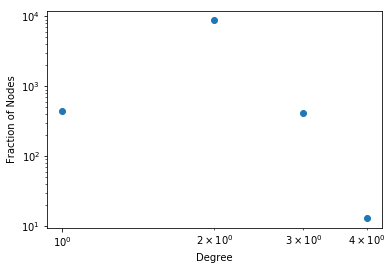

In [171]:
plot_pl(G_watts)

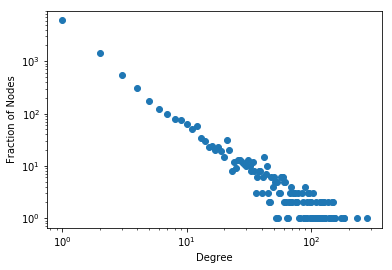

In [170]:
plot_pl(G_un)

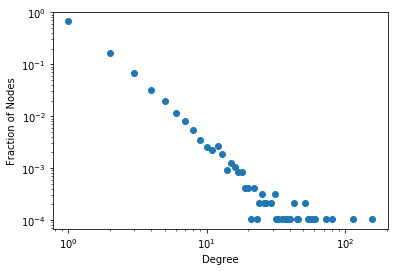

In [141]:
plot_pl(G_power_law)

In [169]:
def plot_pl(G):
    degrees = G.degree()
    degree_values = sorted(set(dict(degrees).values()))
    hist = [list(dict(degrees).values()).count(i) for i in degree_values]
    
    plt.plot(degree_values, hist, 'o')
    plt.xlabel('Degree')
    plt.ylabel('Fraction of Nodes')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

# Predicting New Links

Common Neighbors

In [157]:
common_neighbors = [(e[0], e[1], len(list(nx.common_neighbors(G_un, e[0], e[1])))) for e in nx.non_edges(G_un)]

In [160]:
common_neighbors.sort(key = lambda x: x[2], reverse = True)

In [161]:
common_neighbors[:20]

[('John Adams', 'James Madison', 31),
 ('Thomas Paine', 'Thomas Jefferson', 20),
 ('John Marshall', 'Alexander Hamilton', 20),
 ('Thomas Jefferson', 'John Jay', 20),
 ('George III of the United Kingdom', 'Robert Walpole', 18),
 ('Voltaire', 'Samuel Johnson', 18),
 ('Benjamin Franklin', 'Alexander Hamilton', 17),
 ('George Washington', 'Samuel Johnson', 16),
 ('John Locke', 'Benjamin Franklin', 16),
 ('Thomas Jefferson', 'Samuel Johnson', 16),
 ('Oliver Ellsworth', 'James Madison', 15),
 ('John Adams', 'Samuel Johnson', 15),
 ('John Marshall', 'Presidency of George Washington', 15),
 ('Albin Schram', 'Thomas Carlyle', 15),
 ('George Washington', 'Napoleon', 14),
 ('George Washington', 'William Henry Harrison', 14),
 ('Samuel Adams', 'Benjamin Franklin', 14),
 ('Oliver Cromwell', 'Henrietta Maria of France', 14),
 ('John Locke', 'Richard Price', 14),
 ('Elbridge Gerry', 'Presidency of George Washington', 14)]

Jaccard Coefficient

In [163]:
jaccard = list(nx.jaccard_coefficient(nx.Graph(G_un)))

In [164]:
jaccard.sort(key = lambda x: x[2], reverse = True)

In [165]:
jaccard[:20]

[('Emily Howland', 'Steven Mnuchin', 1.0),
 ('Emily Howland', 'William Still', 1.0),
 ('Emily Howland', 'Thomas Garrett', 1.0),
 ('Emily Howland', 'Jack Lew', 1.0),
 ('Emily Howland', 'Wilbur Henry Siebert', 1.0),
 ('Emily Howland', 'Robert Gould Shaw', 1.0),
 ('Emily Howland', 'Sarah Hopkins Bradford', 1.0),
 ('Emily Howland', 'Cynthia Erivo', 1.0),
 ('Emily Howland', 'Thea Musgrave', 1.0),
 ('Emily Howland', 'Earl Conrad', 1.0),
 ('Emily Howland', 'Susan B. Anthony', 1.0),
 ('Emily Howland', 'James Montgomery', 1.0),
 ('Emily Howland', 'Catherine Clinton', 1.0),
 ('Emily Howland', 'Gerry Whiting Hazelton', 1.0),
 ('Emily Howland', 'Sojourner Truth', 1.0),
 ('Emily Howland', 'Kate Larson', 1.0),
 ('Emily Howland', 'American Civil War spies', 1.0),
 ('Emily Howland', 'Clinton D. MacDougall', 1.0),
 ('Emily Howland', 'Booker T. Washington', 1.0),
 ('Emily Howland', 'Stephen Foster', 1.0)]

Resource Allocation - penalizes neighbors with lots of links already

In [167]:
resources = list(nx.resource_allocation_index(nx.Graph(G_un)))

Preferential Attachment

In [ ]:
pref_attach = list(nx.preferential_attachment(G_un))

Community Structures

In [83]:
graph_3d(G_un, 'Large Wikipedia Network')

C:\ProgramData\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:233: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



The draw time for this plot will be slow for clients without much RAM.


C:\ProgramData\Anaconda3\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [77]:
temp = pd.read_csv("C:\\Users\\forre\\Documents\\Python\\Data Science Projects\\Web Scraping Practice\\Secret\\cred.txt", header = None)

plotly.tools.set_credentials_file(username=temp[0][0].strip(), api_key=temp[1][0].strip())

In [82]:
def graph_3d(G_un, filename):    
    nodes_dict = {}
    for i, v in enumerate(list(G_un.nodes())):
        nodes_dict[v] = i

    Edges = [(nodes_dict[x[0]], nodes_dict[x[1]]) for x in list(G_un.edges())]

    G_ig_un = ig.Graph(Edges, directed = False)

    layt=G_ig_un.layout('fr_3d', dim=3)

    labels= list(G_un.nodes())
    labels = [str(x) for x in labels]

    group = []

    for i in dict(nx.degree(G_un)):
        group.append(dict(nx.degree(G_un))[i])
        
    ma = max(group)
    mi = min(group)
    
    def equalizer(x):
        new_val = ((80-2)*(x-mi))/(ma-mi)
        return new_val
    group = [equalizer(x) for x in group]

    N = len(labels)

    Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
    Yn=[layt[k][1] for k in range(N)]# y-coordinates
    Zn=[layt[k][2] for k in range(N)]# z-coordinates
    Xe=[]
    Ye=[]
    Ze=[]
    for e in Edges:
        Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
        Ye+=[layt[e[0]][1],layt[e[1]][1], None]
        Ze+=[layt[e[0]][2],layt[e[1]][2], None]

    import plotly.plotly as py
    import plotly.graph_objs as go

    trace1=go.Scatter3d(x=Xe,
                   y=Ye,
                   z=Ze,
                   mode='lines',
                   line=dict(color='rgb(125,125,125)', width=1),
                   hoverinfo='none'
                   )
    trace2=go.Scatter3d(x=Xn,
                   y=Yn,
                   z=Zn,
                   mode='markers',
                   name='actors',
                   marker=dict(symbol='circle',
                                 size=[x+6 for x in group],
                                 color=group,
                                 colorscale='Bluered',
                                 line=dict(color='rgb(50,50,50)', width=0.5)
                                 ),
                   text=labels,
                   hoverinfo='text'
                   )
    axis=dict(showbackground=False,
              showline=False,
              zeroline=False,
              showgrid=False,
              showticklabels=False,
              title=''
              )
    layout = go.Layout(
             title="Benjamin Franklin's Wikipedia Network (3D visualization)",
             width=1000,
             height=1000,
             showlegend=False,
             scene=dict(
                 xaxis=dict(axis),
                 yaxis=dict(axis),
                 zaxis=dict(axis),
            ),
         margin=dict(
            t=100
        ),
        hovermode='closest',
        annotations=[
               dict(
               showarrow=False,
                text="Data source: Wikipedia",
                xref='paper',
                yref='paper',
                x=0,
                y=0.1,
                xanchor='left',
                yanchor='bottom',
                font=dict(
                size=14
                )
                )
            ],    )
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)

    return py.iplot(fig, filename = filename, auto_open = True, world_readable = True)